<a href="https://colab.research.google.com/github/Schwarzam/NN-SPLUS/blob/master/Test_S_E_Uncet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
pip install schzz

In [2]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from skimage.io import imread
from sklearn.model_selection import train_test_split
from schzz import RealTime

import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import load_img, img_to_array, save_img
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate, GlobalAveragePooling2D, BatchNormalization

Download Images

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/trainsets/ALLpngsDifBands.zip \
    -O /tmp/Galaxies.zip

--2020-08-19 04:56:49--  https://storage.googleapis.com/trainsets/ALLpngsDifBands.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 848688951 (809M) [application/zip]
Saving to: ‘/tmp/Galaxies.zip’

/tmp/Galaxies.zip   100%[===================>] 809.37M   207MB/s    in 4.1s    

2020-08-19 04:56:54 (200 MB/s) - ‘/tmp/Galaxies.zip’ saved [848688951/848688951]



Extract Imgs, load csv

In [4]:
local_zip = '/tmp/Galaxies.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

base_dir = '/tmp/Galaxies/'

IRG_dir = '/tmp/Galaxies/IRG/'
IGU_dir = '/tmp/Galaxies/IGU/'
ZRG_dir = '/tmp/Galaxies/ZRG/'
R660G_dir = '/tmp/Galaxies/R660G/'

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/Schwarzam/NN-SPLUS/master/ImgsCSV.csv')

In [6]:
df

,Unnamed: 0,FIELD,ID,RA_1,Dec_1,r_petro,zb,zb_Min,zb_Max,PROB_GAL_new,SPIRAL,ELLIPTICAL,UNCERTAIN,simple_class
0,0,STRIPE82-0001,SPLUS.STRIPE82-0001.03217.griz,359.9707,-1.2178,16.50,0.1118,0.083,0.139,1.0,1,0,0,Ec
1,1,STRIPE82-0001,SPLUS.STRIPE82-0001.03462.griz,0.1286,-1.2130,15.80,0.0670,0.061,0.072,1.0,0,0,1,SB
2,2,STRIPE82-0001,SPLUS.STRIPE82-0001.03521.griz,0.0559,-1.2136,16.34,0.0800,0.074,0.079,1.0,1,0,0,SB
3,3,STRIPE82-0001,SPLUS.STRIPE82-0001.03897.griz,0.2156,-1.1983,16.77,0.2070,0.194,0.221,1.0,0,1,0,Er
4,4,STRIPE82-0001,SPLUS.STRIPE82-0001.04092.griz,0.1664,-1.1912,16.88,0.1550,0.081,0.158,1.0,0,0,1,Ei
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8286,8913,STRIPE82-0170,SPLUS.STRIPE82-0170.28231.griz,357.9039,0.8854,15.10,0.0740,0.069,0.076,1.0,0,1,0,Er
8287,8914,STRIPE82-0170,SPLUS.STRIPE82-0170.28516.griz,358.1675,0.8765,16.80,0.1230,0.109,0.123,1.0,0,0,1,Er
8288,8915,STRIPE82-0170,SPLUS.STRIPE82-0170.28780.griz,358.2519,0.8705,16.85,0.1350,0.120,0.140,1.0,0,0,1,Er
8289,8916,STRIPE82-0170,SPLUS.STRIPE82-0170.34215.griz,358.3806,1.2268,15.68,0.0710,0.064,0.083,1.0,1,0,0,S


In [7]:
arr = []

for key, value in df.iterrows():
  if value.SPIRAL == 1:
    arr.append(0)
  if value.ELLIPTICAL == 1:
    arr.append(1)
  if value.UNCERTAIN == 1:
    arr.append(2)

df = df.assign(Class = arr)

In [8]:
df['IRG'] = df['ID'].map(lambda ID: os.path.join(IRG_dir, f'{ID}.png'))
df['IGU'] = df['ID'].map(lambda ID: os.path.join(IGU_dir, f'{ID}.png'))
df['ZRG'] = df['ID'].map(lambda ID: os.path.join(ZRG_dir, f'{ID}.png'))
df['R660G'] = df['ID'].map(lambda ID: os.path.join(R660G_dir, f'{ID}.png'))

in_channel = 3
img_rows, img_cols = 128, 128
num_classes = 3 # number of appliances

input_shape = (img_rows, img_cols, in_channel)
input_img = Input(shape = input_shape)

batch_size = 10
labels = df['Class'].values
arr_labels = df['Class'].values

labels = keras.utils.to_categorical(labels, 3)

In [9]:
def read_spectograms(file_paths, img_rows, img_cols, channels):
  images = []
  
  for file_path in file_paths:
    images.append(imread(file_path))
  
  images = np.asarray(images, dtype=np.float32)
  
  # normalize
  images = images / 255.0 #np.max(images)
  
  # reshape to match Keras expectaions
  images = images.reshape(images.shape[0], img_rows, img_cols, channels)

  return images

In [10]:
x_train_IRG = read_spectograms(df['IRG'].values, img_rows, img_cols, in_channel)
x_train_IGU = read_spectograms(df['IGU'].values, img_rows, img_cols, in_channel)
x_train_ZRG = read_spectograms(df['ZRG'].values, img_rows, img_cols, in_channel)
x_train_R660G = read_spectograms(df['R660G'].values, img_rows, img_cols, in_channel)

[]

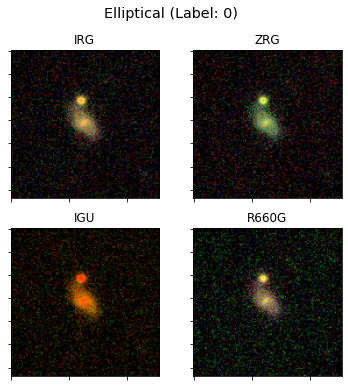

In [11]:
appliances = [
    
    'Elliptical',
    'Lenticular',
    'Merger',
    'Spiral',
    
]

rn_appliance = np.random.choice(df['Class'].values)
rn_label = df['Class'].values[rn_appliance]
rn_IRG = x_train_IRG[rn_appliance]
rn_IGU = x_train_IGU[rn_appliance]
rn_ZRG = x_train_ZRG[rn_appliance]
rn_R660G = x_train_R660G[rn_appliance]

fig, ax = plt.subplots(2, 2, figsize=((6,6)))
plt.suptitle(f"{appliances[rn_label]} (Label: {rn_label})", fontsize="x-large")

curr_img = None

curr_img = np.reshape(rn_IRG, (img_rows, img_cols, in_channel))

ax[0, 0].imshow(curr_img, cmap='gray')
ax[0, 0].set_title("IRG")
ax[0, 0].plot()

ax[0, 0].set_yticklabels([])
ax[0, 0].set_xticklabels([])

curr_img = np.reshape(rn_ZRG, (img_rows, img_cols, in_channel))

ax[0, 1].imshow(curr_img, cmap='gray')
ax[0, 1].set_title("ZRG")
ax[0, 1].plot()

ax[0, 1].set_yticklabels([])
ax[0, 1].set_xticklabels([])

curr_img = np.reshape(rn_IGU, (img_rows, img_cols, in_channel))

ax[1, 0].imshow(curr_img, cmap='gray')
ax[1, 0].set_title("IGU")
ax[1, 0].plot()

ax[1, 0].set_yticklabels([])
ax[1, 0].set_xticklabels([])

curr_img = np.reshape(rn_R660G, (img_rows, img_cols, in_channel))

ax[1, 1].imshow(curr_img, cmap='gray')
ax[1, 1].set_title("R660G")
ax[1, 1].plot()

ax[1, 1].set_yticklabels([])
ax[1, 1].set_xticklabels([])

In [12]:
x_train_comp = np.stack((x_train_IRG, x_train_IGU), axis=4)

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, arr_labels, test_size = 0.3, random_state=666)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.33, random_state=666)
val_labels = y_val

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, labels, test_size = 0.3, random_state=666)


# take them apart
train_IRG = x_train[:,:,:,:,0]
test_IRG = x_test[:,:,:,:,0]

train_IGU = x_train[:,:,:,:,1]
test_IGU = x_test[:,:,:,:,1]

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.33, random_state=666)

test_IRG = x_test[:,:,:,:,0]
val_IRG = x_val[:,:,:,:,0]

test_IGU = x_test[:,:,:,:,1]
val_IGU = x_val[:,:,:,:,1]

del x_train_IRG
del x_train_IGU

In [13]:
x_train_comp = np.stack((x_train_ZRG, x_train_R660G), axis=4)

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, arr_labels, test_size = 0.3, random_state=666)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.33, random_state=666)
val_labels = y_val

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, labels, test_size = 0.3, random_state=666)

# take them apart
train_ZRG = x_train[:,:,:,:,0]
test_ZRG = x_test[:,:,:,:,0]

train_R660G = x_train[:,:,:,:,1]
test_R660G = x_test[:,:,:,:,1]

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.33, random_state=666)

test_ZRG = x_test[:,:,:,:,0]
val_ZRG = x_val[:,:,:,:,0]

test_R660G = x_test[:,:,:,:,1]
val_R660G = x_val[:,:,:,:,1]

del x_train_ZRG
del x_train_R660G

CREATING MODEL

In [14]:
def create_convolution_layers(input_img):
  model = Conv2D(32, (3, 3), padding='same', input_shape=input_shape)(input_img)
  model = MaxPooling2D((2, 2),padding='same')(model)

  model = Conv2D(128, (3, 3), padding='same')(model)
  model = MaxPooling2D((2, 2),padding='same')(model)

  model = Conv2D(256, (3, 3), padding='same')(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
    
  model = Conv2D(512, (3, 3), padding='same')(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)

  return model

In [15]:
IRG_input = Input(shape=input_shape)
IRG_model = create_convolution_layers(IRG_input)
IRG_model = GlobalAveragePooling2D()(IRG_model)

IGU_input = Input(shape=input_shape)
IGU_model = create_convolution_layers(IGU_input)
IGU_model = Flatten()(IGU_model)

ZRG_input = Input(shape=input_shape)
ZRG_model = create_convolution_layers(ZRG_input)
ZRG_model = GlobalAveragePooling2D()(ZRG_model)

R660G_input = Input(shape=input_shape)
R660G_model = create_convolution_layers(R660G_input)
R660G_model = Flatten()(R660G_model)

conv = concatenate([IRG_model, IGU_model, ZRG_model, R660G_model])

dense = Dense(4098)(conv)
dense = Dropout(0.3)(dense)
dense = Dense(4098)(dense)
dense = Dropout(0.3)(dense)
dense = Dense(2048)(dense)
dense = Dropout(0.3)(dense)
dense = Dense(512)(dense)
dense = Dense(256)(dense)

output = Dense(num_classes, activation='softmax')(dense)

model = Model(inputs=[IRG_input, IGU_input, ZRG_input, R660G_input], outputs=[output])

DATA ARGUMENTATION

In [16]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         zoom_range = 0.1,
                         rotation_range = 40)

def gen_flow_for_multiple_inputs(X1, X2, X3, X4, y, batch_size):
    genX1 = gen.flow(X1,y, batch_size=batch_size,seed=666)
    genX2 = gen.flow(X2,y, batch_size=batch_size,seed=666)
    genX3 = gen.flow(X3,y, batch_size=batch_size,seed=666)
    genX4 = gen.flow(X4,y, batch_size=batch_size,seed=666)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            X3i = genX3.next()
            X4i = genX4.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1], X3i[2], x4i[3]], X1i[1], X2i[2]

gen_flow = gen_flow_for_multiple_inputs(train_IRG, train_IGU, train_ZRG, train_R660G, y_train, batch_size)

In [17]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         zoom_range = 0.1,
                         rotation_range = 40)

genX1 = gen.flow(train_IRG, y_train,  batch_size=batch_size,seed=666)

In [18]:
lr = 1e-4
opt = optimizers.RMSprop(learning_rate=lr)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [19]:
model.fit([train_IRG, train_IGU, train_ZRG, train_R660G],
          y_train,
          batch_size=batch_size,
          epochs=20,
          steps_per_epoch = (len(train_IRG)/batch_size),
          validation_data=([test_IRG, test_IGU, test_ZRG, test_R660G], y_test),
          verbose=1,
          callbacks=[RealTime.SendStats('VlL6lzqYZSMlvZN')],
          shuffle=False)

Epoch 1/20
581/580 [==============================] - 80s 138ms/step - loss: 0.8945 - accuracy: 0.6342 - val_loss: 0.9754 - val_accuracy: 0.6405
Epoch 2/20
581/580 [==============================] - 76s 131ms/step - loss: 0.2762 - accuracy: 0.9167 - val_loss: 1.3476 - val_accuracy: 0.6248
Epoch 3/20
 29/580 [>.............................] - ETA: 1:08 - loss: 0.0898 - accuracy: 0.9698

KeyboardInterrupt: ignored